# **Image Classification Models using *tensorflow***

# **Kieran Bissessar**

In this project, a sample of x-rays of people who have been tested COVID positive or negative was observed.
The goal is **build a classifier which can predict the chance of a person having COVID-19**, given their chest x-ray scan.

The dataset for this assignment has been taken from kaggle for healthy pateints and https://github.com/ieee8023/covid-chestxray-dataset for COVID patients. The positive cases are of patients diagonised with COVID. The negative cases are people detected with other forms of infection (not COVID-19) with a few healthy patients mixed in.

## Import Necessary Modules

### Tensorflow Imports

In [1]:
import tensorflow                           as      tf
from   tensorflow.keras                     import  layers, models
from   keras.models                         import  Sequential
from   keras.wrappers.scikit_learn          import  KerasClassifier
from   tensorflow.keras.preprocessing.image import  ImageDataGenerator
from   tensorflow.keras.layers              import  AveragePooling2D
from   tensorflow.keras.layers              import  Dropout
from   tensorflow.keras.layers              import  Flatten
from   tensorflow.keras.layers              import  Dense
from   tensorflow.keras.layers              import  Input
from   tensorflow.keras.models              import  Model
from   tensorflow.keras.optimizers          import  Adam
from   tensorflow.keras.utils               import  to_categorical

Using TensorFlow backend.


### sklearn imports

In [2]:
from   sklearn.preprocessing                import  LabelBinarizer
from   sklearn.model_selection              import  train_test_split
from   sklearn.metrics                      import  classification_report
from   sklearn.metrics                      import  confusion_matrix
from   sklearn.metrics                      import  roc_curve
from   sklearn.metrics                      import  auc

### Misc imports

In [3]:
#import sys
#!{sys.executable} -m pip install imutils
#!{sys.executable} -m pip install opencv-python

In [4]:
# misc. Imports
from   imutils                              import  paths
import matplotlib.pyplot                    as      plt
import numpy                                as      np
import pandas                               as      pd
import argparse
import cv2
import os
import zipfile
import copy

## Unzip Dataset

In [5]:
with zipfile.ZipFile('keras-covid-19.zip', 'r') as zip_ref:
    zip_ref.extractall('');

In [6]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images("./keras-covid-19/dataset"));
data       = []; # holds images
labels     = []; # holds labels associated with image

[INFO] loading images...


In [7]:
#imagePaths ## this should have the path to all the images

## Load Images and Labels

In [8]:
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath) ## all the images are stored as a numpy array
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

In [9]:
### getting the shape of the images
image.shape

(224, 224, 3)

In [10]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data   = np.array(data) / 255.0;
labels = np.array(labels);

# 1 Perform **One Hot Encoding** of the labels

For binary class we sometimes don't need to do one hot encoding since we can assign one as 0 and the other as 1. However in this case we are going to calculate the probability for both outcomes. 

In [11]:
# perform one-hot encoding on the labels 
# hint there should be now two columns in Y
#print(labels);
covidLst  = [];
normalLst = [];

for i in range(len(labels)):
    if (labels[i] == "covid"):
        covidLst.append(1);
        normalLst.append(0);
    else:
        covidLst.append(0);
        normalLst.append(1);
#print(covidLst)
#print(normalLst)
hotLabEncDict = {"covid"  : covidLst,
                 "normal" : normalLst}
labels_cat    = copy.deepcopy(labels);
labels        = pd.DataFrame.from_dict(hotLabEncDict);
labels        = labels.to_numpy()
#labels


# 2 Partition the data into **training and testing splits** using 80% of the data for training and the remaining 20% for testing make sure the output of the split is called as ***trainX***, ***testX***, ***trainY***, ***testY***

In [12]:
trainX, testX, trainY, testY = train_test_split(data,
                                                labels,
                                                test_size    = 0.2,
                                                random_state = 0)

# Perform image augmentation. Rotate the image by upto **15 degrees**

In [13]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range = 15,
    fill_mode      = "nearest")

# 3 Create model. Input takes in images of shape ***( 224 , 224 , 3 )***  and the output is **2**, given that we have 2 labels to predict

In [14]:
INIT_LR = 1e-3 # Initial Learning Rate
EPOCHS  = 25   # Number of Epochs
BS      = 8    # Batch Size

In [15]:
def make_model():
    
    model = models.Sequential()
    
    # Input Layer
    model.add(layers.Conv2D(32, (3,3), input_shape = (224, 224, 3)))
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D(pool_size = (2,2)))
    
    # Hidden Layer 1
    model.add(layers.Conv2D(32, (3,3)))
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D(pool_size = (2,2)))
    
    # Hidden Layer 2
    model.add(Flatten())
    model.add(Dense(32))
    model.add(layers.Activation("relu"))
    
    # Output Layer
    model.add(Dense(2))
    model.add(layers.Activation('sigmoid'))

    return model

In [16]:
model = make_model()


In [17]:
### defining the loss, and compiling the model

# compile our model
print("[INFO] compiling model...")

opt = Adam(lr    = INIT_LR,
           decay = (INIT_LR / EPOCHS))

model.compile(loss      = "binary_crossentropy",
              optimizer = opt,
              metrics   = ["accuracy"])



[INFO] compiling model...


In [18]:
#class TestCallback(tf.keras.callbacks.Callback):
#    def __init__(self, test_data):
#        self.test_data = test_data
#
#    def on_epoch_end(self, epoch, logs={}):
#        x, y = self.test_data
#        loss, acc = self.model.evaluate(x, y, verbose=0)
#        print('\nTesting loss: {}, \nTesting acc: {}\n'.format(loss, acc))

# Q4 **Fit** our model on train data




In [19]:
#hist = model.fit_generator(trainAug.flow(trainX, trainY, batch_size = BS), epochs = EPOCHS);
hist = model.fit(trainAug.flow(trainX, trainY, batch_size = BS), epochs = EPOCHS,
                 validation_data = (testX, testY))
                 #callbacks = [TestCallback((testX, testY))]);

  ...
    to  
  ['...']
Train for 5 steps, validate on 10 samples
Epoch 1/25
5/5 [==============================] - 2s 344ms/step - loss: 0.9165 - accuracy: 0.5500 - val_loss: 0.7497 - val_accuracy: 0.5000
Epoch 2/25
5/5 [==============================] - 1s 245ms/step - loss: 0.6616 - accuracy: 0.6125 - val_loss: 0.6475 - val_accuracy: 0.7000
Epoch 3/25
5/5 [==============================] - 1s 244ms/step - loss: 0.6233 - accuracy: 0.7250 - val_loss: 0.5879 - val_accuracy: 0.6000
Epoch 4/25
5/5 [==============================] - 1s 241ms/step - loss: 0.4938 - accuracy: 0.8375 - val_loss: 0.4420 - val_accuracy: 0.8000
Epoch 5/25
5/5 [==============================] - 1s 241ms/step - loss: 0.3258 - accuracy: 0.9625 - val_loss: 0.3440 - val_accuracy: 0.7500
Epoch 6/25
5/5 [==============================] - 1s 250ms/step - loss: 0.1361 - accuracy: 0.9750 - val_loss: 0.3293 - val_accuracy: 0.8000
Epoch 7/25
5/5 [==============================] - 1s 258ms/step - loss: 0.1127 - accuracy: 0.

In [20]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size = BS)
predIdxs_orig = copy.deepcopy(predIdxs)

[INFO] evaluating network...


In [21]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis = 1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis = 1), predIdxs))#, target_names = np.array(['covid', 'normal'])))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [22]:
print("Actual Results    : ", testY.argmax(axis = 1));
print("Predicted Results : ", predIdxs, "\n");

testVals = testY.argmax(axis = 1);
right=0
for i in range(len(predIdxs)):
    if testVals[i] == predIdxs[i]:
        right+=1
        print("Index: ", i, "\tActual: ", testVals[i], "\t Pred: ", predIdxs[i], "\tCorrect")
    else:
        print("Index: ", i, "\tActual: ", testVals[i], "\t Pred: ", predIdxs[i], "\tWrong")

print("\nAccuracy: ", right, "/" , len(predIdxs), "(" , (right/len(predIdxs))*100 ,"%" , ")" )

Actual Results    :  [1 0 0 1 0 1 1 1 0 0]
Predicted Results :  [1 0 0 1 0 1 1 1 0 0] 

Index:  0 	Actual:  1 	 Pred:  1 	Correct
Index:  1 	Actual:  0 	 Pred:  0 	Correct
Index:  2 	Actual:  0 	 Pred:  0 	Correct
Index:  3 	Actual:  1 	 Pred:  1 	Correct
Index:  4 	Actual:  0 	 Pred:  0 	Correct
Index:  5 	Actual:  1 	 Pred:  1 	Correct
Index:  6 	Actual:  1 	 Pred:  1 	Correct
Index:  7 	Actual:  1 	 Pred:  1 	Correct
Index:  8 	Actual:  0 	 Pred:  0 	Correct
Index:  9 	Actual:  0 	 Pred:  0 	Correct

Accuracy:  10 / 10 ( 100.0 % )


# 5 Calculate the **Accuracy** on the Train and Test Set. Also show the **Confusion Matix** and plot the **ROC Curve**

See [link](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for some background on what actually is ROC curve. We will review this in class.
See [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#) for python example.

The main idea behind using AUC/ROC is that, though the model accuracy is very high, the model might not be learning the important examples well, and one way to check the models ability to check for generalization, is by using the AUC ROC curve

In [23]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(testY.ravel(), predIdxs_orig.ravel())
auc_keras = auc(fpr_keras, tpr_keras)

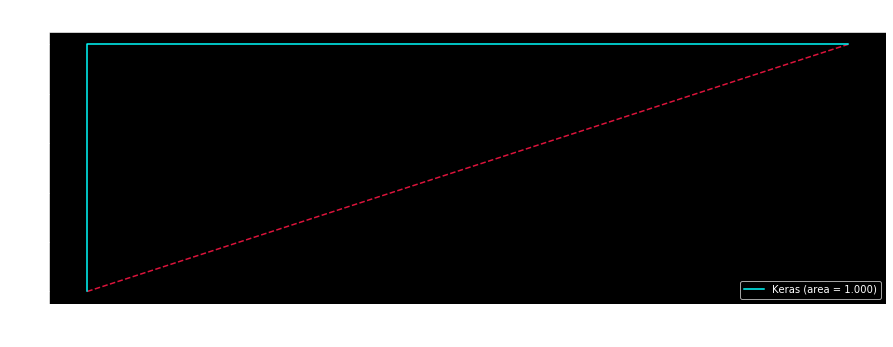

In [24]:
plt.figure(figsize=(15,5))
plt.style.use('dark_background')
plt.title('ROC curve', size = 25)
plt.plot([0, 1], [0, 1], 'k--', color = 'crimson')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras), color = 'cyan')
plt.xlabel('False positive rate', size = 16)
plt.ylabel('True positive rate', size = 16)
plt.legend(loc='best')
plt.show()

Based on the ROC Curve, there seems to be more true positives than false positives. This is good.

## Plot the train and test less and the train and test accuracy for every epoch in one single plot

Most of the time as we increase the number of epochs the model performs better on train set but, starts to perform worse on validation set. In such cases, we use these plots, to decide which is the most optimal epoch at which the model dosent overfit, and we take the model corresponding to that epoch to test on unseen examples.

Tensorflow lets you save your model after every epoch, you can also experiment with saving and loading the trained models (Optional)

In [25]:
#print("Train Metrics")
#train_results = model.evaluate (trainX , trainY , batch_size = BS);
#print("\tTrain Loss     : " , train_results[0] , "\n\tTrain Accuracy : " , train_results[1] , "\n")
#print("Test Metrics")
#test_results  = model.evaluate (testX  , testY  , batch_size = BS);
#print("\tTest Loss      : " , test_results[0] , "\n\tTest Accuracy  : "  , test_results[1]  , "\n")

<function matplotlib.pyplot.show(*args, **kw)>

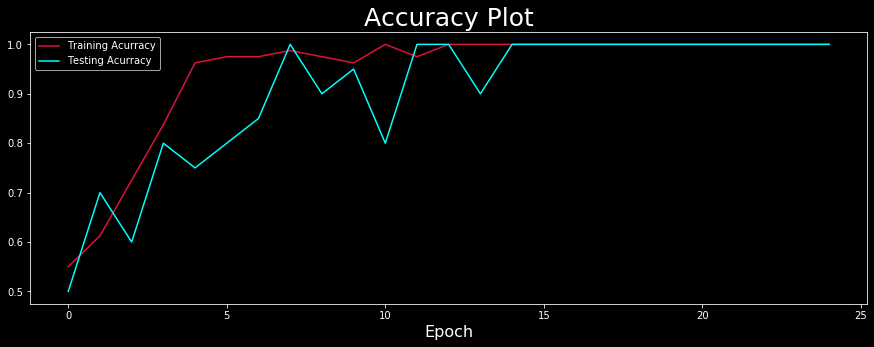

In [26]:
train_acc  = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc   = hist.history['val_accuracy']
test_loss = hist.history['val_loss']


epochs = range(EPOCHS)
plt.figure(figsize=(15,5))
plt.style.use('dark_background')
plt.title("Accuracy Plot", size = 25)
plt.plot(epochs, train_acc, label = 'Training Acurracy', color = "crimson")
plt.plot(epochs, test_acc, label = 'Testing Acurracy', color = "cyan")
plt.legend();
plt.xlabel("Epoch", size = 16)
plt.show
#plt.plot(epochs, loss, label = 'Loss', color = 'limegreen')



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<function matplotlib.pyplot.show(*args, **kw)>

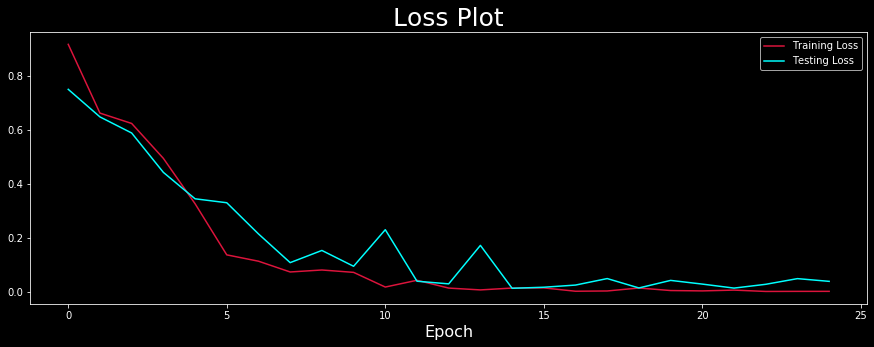

In [27]:
acc  = hist.history['accuracy']
loss = hist.history['loss']
print(hist.history.keys())
epochs = range(EPOCHS)
plt.style.use('dark_background')
plt.figure(figsize=(15,5))
plt.title("Loss Plot", size = 25)
plt.plot(epochs, train_loss, label = 'Training Loss', color = "crimson")
plt.plot(epochs, test_loss, label = 'Testing Loss', color = "cyan")
plt.legend();
plt.xlabel("Epoch", size = 16)
plt.show

[[5 0]
 [0 5]]


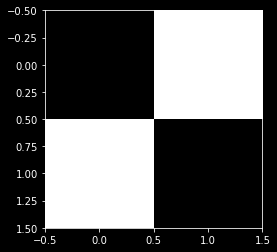

In [28]:
disp = confusion_matrix(testY.argmax(axis = 1), predIdxs)
print(disp)
plt.imshow(disp, cmap='binary', interpolation='None')
plt.show()

# A model can have an **accuracy of 99%** and still **not be considered a good model**

It is very possible to have a case where the model accuracy is very high and still is a bad model. This happens when **overfitting** is present. In this case the model begins to just memorize the data instead of trying to understand ways to classify it. This is no good and can happen if there is an excessive number of epochs or if there are lots of parameters trained on a **small dataset**.